# 导入包

In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import rl_utils
import os
from tqdm import tqdm

# 策略网络

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)  # 输出各动作的概率

# REIFORCE算法

In [3]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim, learning_rate, gamma,
                 device):
        self.policy_net = PolicyNet(state_dim, hidden_dim,
                                    action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(), lr=learning_rate)  # 使用Adam优化器
        self.gamma = gamma  # 折扣因子
        self.device = device
    def take_action(self, state):  # 根据动作概率分布随机采样
        state = torch.tensor(state[np.newaxis, :], dtype=torch.float).to(self.device)
        probs = self.policy_net(state)  # 给state加一个维度
        action_dist = torch.distributions.Categorical(probs)  # 根据probs给出的概率创建一个类别分布
        action = action_dist.sample()  # 从创建的类别分布中抽样, 得到某个类别的序号
        return action.item()

    def update(self, transition_dict):
        return_list = transition_dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad() # 设定0梯度
        for i in reversed(range(len(return_list))):  # 从最后一步算起, 对每一个状态动作计算损失
            reward = return_list[i]
            state = torch.tensor(state_list[i], dtype=torch.float).to(self.device)
            action = torch.tensor(action_list[i]).view(-1, 1).to(self.device)  # 选择当前步骤的动作
            log_prob = torch.log(self.policy_net(state.unsqueeze(0)).gather(1, action))  # 依据动作选概率, 对数化
            G = self.gamma * G + reward
            loss = -log_prob * G  # 每一步的损失函数
            loss.backward()  # 反向传播计算梯度, 在循环中一直积累梯度
        self.optimizer.step()  # 梯度下降, 每轮游戏结束后计算的总损失梯度全部更新一次

## ✅注意点

策略梯度的损失，不是与正确的动作来对比得到交叉熵，因为我们事先不知道正确的动作，所以没有参考，因此就只能人为确定一种损失，例如用网络给出的各个动作的概率，乘以当前得到的奖励，如果奖励比较低，乘起来也比较小，我们希望提升奖励，所以加个负号再执行梯度下降，等于是做了梯度上升，也就希望提升奖励，因为概率肯定是正的，所以是提升奖励，那么奖励越小，反之同理，符合我们调整参数的目标。

# 参数初始化

In [4]:
# 模型相关
s_epoch = 0
total_epoch = 5
s_episode = 0
total_episode = 1000
torch.manual_seed(0)
best_score = 0
return_list = []
gamma = 0.98  # 折扣率
learning_rate = 1e-3  # 学习率
env_name = "CartPole-v1"
env = gym.make(env_name)

# 神经网络相关
hidden_dim = 128
state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

# 读取检查点

In [5]:
def read_ckp(ckp_path):
    if os.path.exists(ckp_path):
        checkpoint = torch.load(ckp_path)
        s_epoch = checkpoint['epoch']
        s_episode = checkpoint['episode']
        agent.policy_net.load_state_dict(checkpoint['best_weight'])
        return_list = checkpoint['return_list']
        return s_epoch, s_episode, return_list
    else:
        s_epoch = 0
        s_episode = 0
        return_list = []
        return s_epoch, s_episode, return_list

In [6]:
CKP_PATH = 'checkpoints/REINFORCE_CPv1.pt'
s_epoch, s_episode, return_list = read_ckp(CKP_PATH)

# 训练策略

In [7]:
for epoch in range(s_epoch, total_epoch):
    with tqdm(total=(total_episode - s_episode), desc='<%d/%d>' % (epoch + 1, total_epoch), leave=False) as pbar:
        for episode in range(s_episode, total_episode):
            episode_reward = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states': [],
                'rewards': [],
                'dones': [],
                'truncated' : [],
            }
            state = env.reset()[0]
            done = truncated = False
            while not (done | truncated):
                action = agent.take_action(state)
                next_state, reward, done, truncated, _ = env.step(action)
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                transition_dict['truncated'].append(truncated)
                
                state = next_state
                episode_reward += reward
            return_list.append(episode_reward)
            agent.update(transition_dict)
            
            if episode_reward > best_score:
                best_weight = agent.policy_net.state_dict()
                best_score = episode_reward
            
            if (episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (total_episode * epoch + episode + 1),
                    'recent_return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            
            torch.save({
            'epoch': epoch,
            'episode': episode,
            'best_weight': best_weight,
            'return_list': return_list,
            }, CKP_PATH)
                
            pbar.update(1)
        s_episode = 0
        
agent.policy_net.load_state_dict(best_weight)  # 应用最佳权重

<All keys matched successfully>

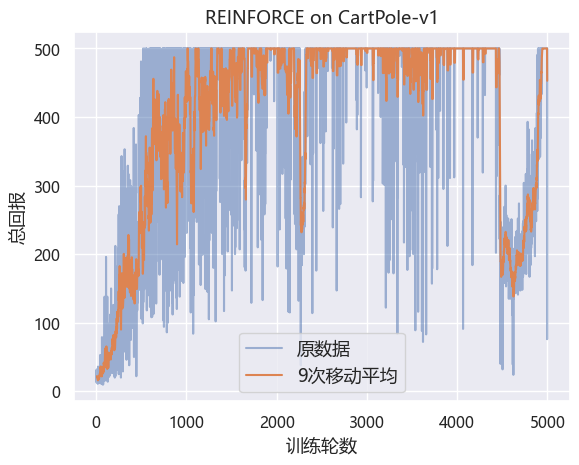

In [9]:
rl_utils.picture_return(return_list, 'REINFORCE', env_name, 9)